In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import requests
import io
from datetime import datetime
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from collections import Counter
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve


In [95]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [96]:
data_orders = pd.read_feather('C:\\Users\\Barbos-Rapitos\\Desktop\\Repetit.ru\\datasets\\orders.feather')
data_prefered_teachers_order_id = pd.read_feather('C:\\Users\\Barbos-Rapitos\\Desktop\\Repetit.ru\\datasets\\prefered_teachers_order_id.feather')
data_suitable_teachers = pd.read_feather('C:\\Users\\Barbos-Rapitos\\Desktop\\Repetit.ru\\datasets\\suitable_teachers.feather')
data_teachers_info= pd.read_feather('C:\\Users\\Barbos-Rapitos\\Desktop\\Repetit.ru\\datasets\\teachers_info.feather')

In [97]:
data_suitable_teachers

,teacher_id,order_id,contact_result,enable_auto_assign,enable_assign
0,82583,1742711,Репетитор согласился,1,1
1,125057,1742713,"Репетитор положил трубку, либо обрыв связи (Oktell)",0,0
2,231211,1742713,"Репетитор положил трубку, либо обрыв связи (Oktell)",0,0
3,128773,1742713,"Репетитор положил трубку, либо обрыв связи (Oktell)",0,0
4,63019,1742713,Репетитор согласился,0,1
...,...,...,...,...,...
20271181,292878,2946697,NaN,0,0
20271182,36028,2946079,NaN,0,0
20271183,180592,2946079,NaN,0,0
20271184,87326,2946079,NaN,0,0


In [98]:
# Преобразование столбцов в формат datetime
data_teachers_info['date_update'] = pd.to_datetime(data_teachers_info['date_update'])
# Удаление времени из столбца
data_teachers_info['date_update'] = data_teachers_info['date_update'].dt.strftime('%Y-%m-%d')
data_teachers_info['reg_date'] = pd.to_datetime(data_teachers_info['reg_date'])
data_teachers_info['reg_date'] = data_teachers_info['reg_date'].dt.strftime('%Y-%m-%d')
data_teachers_info['birth_date'] = pd.to_datetime(data_teachers_info['birth_date'])
data_teachers_info['teaching_start_date'] = pd.to_datetime(data_teachers_info['teaching_start_date'])

In [99]:
data_teachers_info['display_days'].isna().sum()

0

In [100]:
data_teachers_info.head(3)

,id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
0,33,2023-11-07,2007-12-24,1983-06-05,1989-09-01,45,0,0,0,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,"[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Как узнать сколько знаков написал, чтобы выйти на максимальный рейтинг по данному разделу? Нет счетчика количества знаков...[/p][p]&nbsp;[/p][p]родордророрлуот&nbsp;[/p][p]&nbsp;[/p]",1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,"[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Как узнать сколько знаков написал, чтобы выйти на максимальный рейтинг по данному разделу? Нет счетчика количества знаков...[/p][p]&nbsp;[/p][p]родордророрлуот&nbsp;[/p][p]&nbsp;[/p]",1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,/teachers/33/photo/photo_small.jpg,"[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Как узнать сколько знаков написал, чтобы выйти на максимальный рейтинг по данному разделу? Нет счетчика количества знаков...[/p][p]&nbsp;[/p][p]родордророрлуот&nbsp;[/p][p]&nbsp;[/p]",1,1,15,5,Швачко М.Н. 15.01.2018 14:59 - 33\r\nАникеева А.В. 03.04.2019 12:12 - тест\r\nНейман В.Л. 10.02.2023 17:11 - Тестовый коммент\r\nНейман В.Л. 10.02.2023 17:13 - test\r\nНиколаев А.В. 12.09.2023 13:40 - test1\r\nНиколаев А.В. 12.09.2023 13:40 - test2\r\nНиколаев А.В. 12.09.2023 13:40 - test4\r\nНиколаев А.В. 12.09.2023 13:40 - test883\n\net\nset\n\n\nset\n\n!\r\nНиколаев А.В. 12.09.2023 17:24 - Длинныйпредлинныйпредлинныйпредлинныйпредлинныйпредлинныйпредлинныйпредлинныйпредлинныйпредлинныйпредлинный комментарий\r\nНиколаев А.В. 12.09.2023 17:25 - Длинныйпредлинныйпредлинныйпредлинныйпредлинныйпредлинный предлинныйпредлинныйпредлинный предлинныйпредлинный комментарий,2016-02-12 21:06:51.000,2022-10-24 16:48:38.410,1.0,0,4.679688,1,NaN,1,500,1,NaN,0,1,0,1138.0,237.5,NaN,1,0,492.0,1,NaN,NaN,4.500000,1138.0,6,2022-05-16 18:44:59.993,0,3702.0,2023-11-06 14:20:15.173
1,46,2023-01-19,2007-12-24,1980-02-12,2003-09-01,63,0,1,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,/teachers/46/photo/photo_small.webp,NaN,1,0,4,-3,NaN,2014-08-12 00:00:00.000,NaN,1.0,0,0.000000,1,NaN,3,0,0,NaN,0,1,1,25.0,0.0,NaN,1,1,0.0,1,NaN,NaN,4.300781,25.0,0,2017-01-01 00:00:00.000,1,NaN,NaN
2,51,2023-05-25,2007-12-24,1965-04-30,1988-09-01,68,0,0,0,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,"[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои ученики сдают ЕГЭ на высокие баллы (в 2022 году - 96 и 98 баллов). Подробно прорабатываю с учеником каждую тему. Особое внимание уделяю творческим работам: часто ученики не знают, что писать в изложении и сочинении, но после нескольких занятий со мной начинают понимать, что это совсем несложно.[/p][p]С отстающими школьниками занимаюсь так, чтобы не только устранить текущие пробелы в знаниях, но и пройти 1-2 темы вперед - так ребенок лучше поймет&nbsp;их в школе.&nbsp;[/p][p]Работаю онла

In [101]:
data_teachers_info.columns

Index(['id', 'date_update', 'reg_date', 'birth_date', 'teaching_start_date',
       'user_id', 'is_email_confirmed', 'is_home_lessons',
       'is_external_lessons', 'external_comments', 'lesson_duration',
       'lesson_cost', 'status_id', 'status_relevant_date', 'status_school_id',
       'status_college_id', 'status_display', 'russian_level_id',
       'home_country_id', 'information', 'is_confirmed', 'external_comments.1',
       'lesson_duration.1', 'lesson_cost.1', 'status_id.1',
       'status_relevant_date.1', 'status_school_id.1', 'status_college_id.1',
       'status_display.1', 'russian_level_id.1', 'home_country_id.1',
       'information.1', 'is_confirmed.1', 'external_comments.2',
       'lesson_duration.2', 'lesson_cost.2', 'status_id.2',
       'status_relevant_date.2', 'status_school_id.2', 'status_college_id.2',
       'status_display.2', 'russian_level_id.2', 'home_country_id.2',
       'photo_path', 'information.2', 'is_confirmed.2', 'is_display',
       'rating_id'

In [102]:
# Объединяем таблицы по столбцу "teacher_id"
data_teachers_merged = pd.merge(data_suitable_teachers, data_teachers_info, left_on='teacher_id', right_on='id')

# Выводим объединенную таблицу
data_teachers_merged.head(1)

,teacher_id,order_id,contact_result,enable_auto_assign,enable_assign,id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
0,82583,1742711,Репетитор согласился,1,1,82583,2023-01-19,2015-02-16,1981-02-02,2000-09-01,83886,0,1,0,NaN,45,600,3,NaN,4028.0,NaN,0,5,7,"[p]Лауреат всероссийских и международных конкурсов исполнителей. Победитель городских и областных конкурсов преподавателей. Участник известного дуэта ""Виртуозы гитары"". В числе учеников - лауреаты более 40 различных конкурсов: от городских до международных. Научит Вас играть на гитаре быстро, интересно и качественно. Программа по Вашему желанию - игра по нотам, табулатурам или подбор мелодий. От аккордов до виртуозной игры в любом жанре.[/p]",1,NaN,45,600,3,NaN,4028.0,NaN,0,5,7,"[p]Лауреат всероссийских и международных конкурсов исполнителей. Победитель городских и областных конкурсов преподавателей. Участник известного дуэта ""Виртуозы гитары"". В числе учеников - лауреаты более 40 различных конкурсов: от городских до международных. Научит Вас играть на гитаре быстро, интересно и качественно. Программа по Вашему желанию - игра по нотам, табулатурам или подбор мелодий. От аккордов до виртуозной игры в любом жанре.[/p]",1,NaN,45,600,3,NaN,4028.0,NaN,0,5,7,/teachers/82583/photo/photo_small.webp,"[p]Лауреат всероссийских и международных конкурсов исполнителей. Победитель городских и областных конкурсов преподавателей. Участник известного дуэта ""Виртуозы гитары"". В числе учеников - лауреаты более 40 различных конкурсов: от городских до международных. Научит Вас играть на гитаре быстро, интересно и качественно. Программа по Вашему желанию - игра по нотам, табулатурам или подбор мелодий. От аккордов до виртуозной игры в любом жанре.[/p]",1,1,15,5,NaN,2014-08-12 00:00:00.000,2019-11-01 11:36:18.830,NaN,0,0.0,12,NaN,1,0,0,NaN,1,1,1,150.0,0.0,NaN,1,1,3180.0,0,0.0,NaN,4.300781,150.0,0,2017-01-01 00:00:00.000,1,7136.0,NaN


In [103]:
numeric_columns = data_teachers_merged.select_dtypes(include=[np.number]).columns

numeric_columns

Index(['teacher_id', 'order_id', 'enable_auto_assign', 'enable_assign', 'id',
       'user_id', 'is_email_confirmed', 'is_home_lessons',
       'is_external_lessons', 'lesson_duration', 'lesson_cost', 'status_id',
       'status_school_id', 'status_college_id', 'status_display',
       'russian_level_id', 'home_country_id', 'is_confirmed',
       'lesson_duration.1', 'lesson_cost.1', 'status_id.1',
       'status_school_id.1', 'status_college_id.1', 'status_display.1',
       'russian_level_id.1', 'home_country_id.1', 'is_confirmed.1',
       'lesson_duration.2', 'lesson_cost.2', 'status_id.2',
       'status_school_id.2', 'status_college_id.2', 'status_display.2',
       'russian_level_id.2', 'home_country_id.2', 'is_confirmed.2',
       'is_display', 'rating_id', 'rating', 'is_pupils_needed',
       'is_cell_phone_confirmed', 'effective_rating', 'area_id', 'sex',
       'amount_to_pay', 'is_remote_lessons', 'show_on_map', 'send_mailing',
       'send_suitable_orders', 'rating_for_use

In [104]:
# Заполнить отсутствующие значения -1 только в числовых столбцах
data_teachers_merged[numeric_columns] = data_teachers_merged[numeric_columns].fillna(-1)

In [105]:
# Преобразовать непустые значения в 1 и пустые значения в 0 для столбца 'information'
data_teachers_merged['information_flag'] = data_teachers_merged['information'].apply(lambda x: 1 if pd.notnull(x) else 0)

# Преобразовать непустые значения в 1 и пустые значения в 0 для столбца 'photo_p
data_teachers_merged['photo_path_flag'] = data_teachers_merged['photo_path'].apply(lambda x: 1 if pd.notnull(x) else 0)

In [106]:
# Преобразовать столбцы 'Categorical' в 'Timestamp'
data_teachers_merged['teaching_start_date'] = pd.to_datetime(data_teachers_merged['teaching_start_date'])
data_teachers_merged['reg_date'] = pd.to_datetime(data_teachers_merged['reg_date'])

# Рассчитать возраст в годах на основе 'birth_date'
data_teachers_merged['age_in_years'] = ((datetime.now() - data_teachers_merged['birth_date']) / pd.Timedelta(days=365.25)).astype(int)

# Рассчитать опыт преподавания в годах на основе 'teaching_start_date'
data_teachers_merged['teaching_experience_in_years'] = ((datetime.now() - data_teachers_merged['teaching_start_date']) / pd.Timedelta(days=365.25)).astype(int)

# Рассчитать время на платформе в годах на основе 'reg_date'
data_teachers_merged['time_on_platform_in_years'] = ((datetime.now() - data_teachers_merged['reg_date']) / pd.Timedelta(days=365.25)).astype(int)

In [107]:
# Применяем One-Hot Encoding
data_teachers_merged = pd.get_dummies(data_teachers_merged, columns=['sex'], prefix='sex')


In [108]:
# Применяем One-Hot Encoding в столбце status_id который обозначает роль репетиора в teacher_info!
data_teachers_merged = pd.get_dummies(data_teachers_merged, columns=['status_id'], prefix='', prefix_sep='')

# Переименовываем столбцы для повышения понимания
column_mapping = {
    '1': 'student_count',
    '2': 'aspirant_count',
    '3': 'teacher_count',
    '4': 'prof_count',
    '5': 'priv_count',
    '7': 'native_count'
}
data_teachers_merged = data_teachers_merged.rename(columns=column_mapping)

In [109]:
# Создаем словарь для агрегированных операций
aggregations = {
    'teacher_id': 'count',
    'is_email_confirmed': 'sum',
    'is_home_lessons': 'sum',
    'is_external_lessons': 'sum',
    'is_pupils_needed': 'sum',
    'is_cell_phone_confirmed': 'sum',
    'is_remote_lessons': 'sum',
    'is_confirmed': 'sum',
    'information_flag': 'sum',
    'photo_path_flag': 'sum',
    'time_on_platform_in_years': ['min', 'max', 'mean'],
    'teaching_experience_in_years': ['min', 'max', 'mean'],
    'age_in_years': ['min', 'max', 'mean'],
    'lesson_cost': ['min', 'max', 'mean'],
    'lesson_duration': ['min', 'max', 'mean'],
    'student_count': 'sum',
    'aspirant_count': 'sum',
    'teacher_count': 'sum',	'prof_count': 'sum',
    'priv_count': 'sum',
    'native_count': 'sum',
    'russian_level_id': ['mean', 'max'],
    'sex_1': 'sum',
    'sex_2': 'sum',
    'sex_3': 'sum',
    'rating': ['min', 'max', 'mean'],
    'effective_rating': ['min', 'max', 'mean'],
    'rating_for_users': ['min', 'max', 'mean'],
    'rating_for_admin': ['min', 'max', 'mean'],
    'display_days': ['min', 'max', 'mean'],
    'star_rating': ['min', 'max', 'mean'],
    'rating_for_users_yesterday': ['min', 'max', 'mean']
}

# Применяем операции агрегации
grouped_data = data_teachers_merged.groupby('order_id', as_index=False).agg(aggregations)

# Переименовываем столбцы без создания вложенных названий
grouped_data.columns = [f'{col[0]}_{col[1]}' if isinstance(col, tuple) else col for col in grouped_data.columns]
grouped_data.rename(columns={'order_id_': 'order_id'}, inplace=True)

In [110]:
grouped_data.head(5)

,order_id,teacher_id_count,is_email_confirmed_sum,is_home_lessons_sum,is_external_lessons_sum,is_pupils_needed_sum,is_cell_phone_confirmed_sum,is_remote_lessons_sum,is_confirmed_sum,information_flag_sum,photo_path_flag_sum,time_on_platform_in_years_min,time_on_platform_in_years_max,time_on_platform_in_years_mean,teaching_experience_in_years_min,teaching_experience_in_years_max,teaching_experience_in_years_mean,age_in_years_min,age_in_years_max,age_in_years_mean,lesson_cost_min,lesson_cost_max,lesson_cost_mean,lesson_duration_min,lesson_duration_max,lesson_duration_mean,student_count_sum,aspirant_count_sum,teacher_count_sum,prof_count_sum,priv_count_sum,native_count_sum,russian_level_id_mean,russian_level_id_max,sex_1_sum,sex_2_sum,sex_3_sum,rating_min,rating_max,rating_mean,effective_rating_min,effective_rating_max,effective_rating_mean,rating_for_users_min,rating_for_users_max,rating_for_users_mean,rating_for_admin_min,rating_for_admin_max,rating_for_admin_mean,display_days_min,display_days_max,display_days_mean,star_rating_min,star_rating_max,star_rating_mean,rating_for_users_yesterday_min,rating_for_users_yesterday_max,rating_for_users_yesterday_mean
0,1742638,13,0,6,11,-11.0,0,11,13,10.0,12.0,3,15,5.846154,5,16,8.153846,23,34,27.538462,0,2500,776.923077,60,60,60.0,2,2,0,0,9,0,4.615385,5,13,0,0,-1,7,5.692308,0.0,12.0,0.923077,75.0,3262.0,994.15387,0.0,1770.0,519.211548,883.5,3682.0,1824.346191,4.300781,5.000000,4.715445,75.0,3624.0,1022.000000
1,1742639,1,0,0,1,-1.0,0,1,1,0.0,1.0,3,3,3.000000,11,11,11.000000,34,34,34.000000,1000,1000,1000.000000,60,60,60.0,0,0,0,0,0,1,1.000000,1,0,1,0,6,6,6.000000,0.0,0.0,0.000000,805.5,805.5,805.50000,614.0,614.0,614.000000,1102.0,1102.0,1102.000000,4.898438,4.898438,4.898438,805.5,805.5,805.500000
2,1742650,3,0,2,3,-3.0,0,3,3,3.0,2.0,2,9,4.666667,9,37,18.666667,27,57,37.000000,0,400,133.333333,60,60,60.0,0,0,0,0,3,0,5.000000,5,0,3,0,5,7,5.666667,0.0,0.0,0.000000,300.0,884.0,591.50000,0.0,490.5,301.500000,883.5,2524.0,1530.500000,4.300781,5.000000,4.766927,300.0,884.0,591.500000
3,1742651,3,0,0,2,-3.0,0,1,3,2.0,2.0,3,10,6.333333,8,24,18.333333,26,73,47.666667,600,3000,1533.333333,60,60,60.0,1,0,1,0,1,0,5.000000,5,1,2,0,5,7,6.000000,0.0,8.0,2.666667,900.0,2136.0,1432.00000,450.0,2200.0,1486.333374,1356.0,3494.0,2335.333252,4.898438,5.000000,4.966146,900.0,2002.0,1387.333374
4,1742654,4,0,4,3,-4.0,0,4,4,2.0,4.0,3,12,7.500000,12,33,19.250000,33,58,41.500000,0,1300,775.000000,60,90,67.5,0,0,3,0,1,0,5.000000,5,0,4,0,-1,7,2.750000,0.0,6.0,1.500000,245.0,1025.0,603.12500,0.0,1800.0,510.375000,668.5,1806.0,1329.875000,4.300781,5.000000,4.799805,245.0,1025.0,603.125000


In [111]:
grouped_data.shape

(842019, 58)

In [112]:
# Преобразование столбца в целочисленный тип
#data_orders['original_order_id'] = data_orders['original_order_id'].astype(float).astype('Int64')
#data_orders['id'] = data_orders['id'].astype('Int64')
float_cols = data_orders.select_dtypes(include=['float32']).columns

for col in float_cols:
    data_orders[col] = data_orders[col].astype(pd.Int64Dtype())

In [113]:
data_orders = pd.merge(data_orders, grouped_data, how='inner', left_on='id', right_on='order_id')

In [114]:
data_orders.shape

(833524, 96)

In [115]:
data_orders = data_orders.reset_index(drop=True)

In [116]:
data_orders = data_orders.drop_duplicates()

In [117]:
# Преобразовать столбец 'order_date' в формат даты и времени
data_orders['order_date'] = pd.to_datetime(data_orders['order_date'], format='mixed', errors='coerce')

# Подсчитать количество значений NaN (недопустимых значений) в столбце 'order_date'
data_orders['order_date'].isna().sum()

0

In [118]:
# Удаление столбцов с NaT в столбце 'order_date'
data_orders = data_orders.dropna(subset=['order_date'])

In [119]:
# Значения 3211265, 3342337, 3605505 являются ошибочными. Удалим их из датасета
data_orders = data_orders[~data_orders.isin([3211265, 3342337, 3605505]).any(axis=1)]

In [120]:
# Создать столбец 'target' на основе значений столбца 'status_id'
data_orders.loc[:, 'target'] = data_orders['status_id'].apply(lambda x: 1 if x in [5, 6, 13, 15] else 0)

In [121]:
# Удалить столбцы не известные на момент формирования заявки
columns_to_drop = ['start_date', 'comments', 'estimated_fee', 'first_lesson_date',\
    'lesson_place', 'working_teacher_id', 'additional_status_id', 'prefered_teacher_id', 'payment_date', 'status_id', 'amount_to_pay']
data_orders = data_orders.drop(columns=columns_to_drop)

In [122]:
# Получить список значений 'original_order_id' при заданном условии
filtered_ids = data_orders.loc[(data_orders['original_order_id'].notnull()) & (data_orders['target'] == 1), 'original_order_id'].tolist()
# Изменить значение столбца 'target' на 1 для полученных значений 'original_order_id'
data_orders.loc[data_orders['original_order_id'].isin(filtered_ids), 'target'] = 1
# Изменить значение столбца 'target' на 1 для полученных значений 'id'
data_orders.loc[data_orders['id'].isin(filtered_ids), 'target'] = 1

In [123]:
data_orders.target.value_counts()

target
0    632684
1    200366
Name: count, dtype: int64

In [124]:
# Получить id всех дубликатов, исключая аномалию, когда в строке id = original_order_id
filtred_dup = data_orders.loc[(data_orders['original_order_id'].notnull()) & (data_orders['original_order_id'] != data_orders['id'])]['id'].tolist()
len(filtred_dup)

377547

In [125]:
# Размерность дубликатов дубликатов
data_orders[data_orders['original_order_id'].isin(filtred_dup)].shape

(11175, 86)

In [126]:
# Получаем список id всех дубликатов дубликатов 
filtred_dup_dup = data_orders[data_orders['original_order_id'].isin(filtred_dup)]['id']

In [127]:
# Получаем список всех дубликатов дубликатов дубликатов
data_orders[(data_orders['original_order_id'].isin(filtred_dup_dup))&(data_orders['original_order_id'] != data_orders['id'])].shape

(954, 86)

In [128]:
# Получаем список id всех дубликатов дубликатов дубликатов
filtred_dup_dup_dup = data_orders[data_orders['original_order_id'].isin(filtred_dup_dup)]['id']
# Получаем список всех дубликатов дубликатов дубликатов дубликатов
data_orders[(data_orders['original_order_id'].isin(filtred_dup_dup_dup))&(data_orders['original_order_id'] != data_orders['id'])].shape

(642, 86)

In [129]:
# Получаем список id всех дубликатов дубликатов дубликатов дубликатов
filtred_dup_dup_dup_dup = data_orders[data_orders['original_order_id'].isin(filtred_dup_dup_dup)]['id']
# Получаем список всех дубликатов дубликатов дубликатов дубликатов дубликатов
data_orders[(data_orders['original_order_id'].isin(filtred_dup_dup_dup_dup))&(data_orders['original_order_id'] != data_orders['id'])].shape

(620, 86)

Пока не решил что делать с дубликатами дубликатов итд

In [130]:
# Сортируем данные по полю 'id' по возрастанию
data_orders = data_orders.sort_values(by=['id'])

# Создаём новый столбец 'request_number' со значением 2 для первой заявки в каждой группе иначе 0
data_orders['order_number'] = data_orders.groupby('original_order_id').cumcount().add(2)

In [131]:
# Запомнить номера из столбца 'original_order_id'
original_order_ids = data_orders['original_order_id'].tolist()

# Выполнить поиск и замену значений в столбце 'order_number'
data_orders.loc[data_orders['id'].isin(original_order_ids), 'order_number'] = 1

In [132]:
non_matching_ids = data_orders.loc[data_orders['original_order_id'].notna() & ~data_orders['original_order_id'].isin(data_orders['id']), 'original_order_id']

In [133]:
data_orders['purpose'].fillna('unknown', inplace=True)
data_orders['home_metro_id'].fillna(-1, inplace=True)
data_orders['add_info'].fillna('unknown', inplace=True)
data_orders['creator_id'].fillna(-1, inplace=True)
data_orders['pupil_category_new_id'].fillna(-1, inplace=True)
data_orders['original_order_id'].fillna(-1, inplace=True)
data_orders['max_metro_distance'].fillna(-1, inplace=True)

In [134]:
# Модель Bert не понимает что такое огэ, егэ. Расшифруем для лучшей интерпретации.
data_orders['purpose'] = data_orders['purpose'].replace({'егэ': 'единый гос. экзамен', 'огэ': 'основной гос. экзамен'}, regex=True)

In [135]:
# Функция для удаления символов \u200b
def remove_special_characters(text):
    return re.sub(r'\u200b', '', text)

# Применение функции к столбцу 'purpose'
data_orders['purpose'] = data_orders['purpose'].apply(remove_special_characters)

In [136]:
def count_phrase_occurrences(data, column):
    # Создание списка для всех слов и фраз
    all_words = []

    # Проход по каждой строке столбца
    for phrase in data[column]:
        # Извлечение первого слова или фразы перед первым двоеточием
        match = re.search(r"^([^:\n]+):\s*", phrase)
        if match:
            all_words.append(match.group(1))

        # Поиск фраз или слов между \n и :
        matches = re.findall(r"\n([^:\n]+):\s*", phrase)
        all_words.extend(matches)

    # Подсчет частоты для каждого слова или фразы
    word_counts = Counter(all_words)

    # Фильтрация слов и фраз, которые встречаются более 100 раз
    unique_words = [word for word, count in word_counts.items() if count > 100]

    # Создание нового столбца с числом вхождений фраз
    new_column_name = column + '_phrase_count'
    data[new_column_name] = data[column].apply(lambda x: sum(x.count(phrase) for phrase in unique_words))

    return data

In [137]:
# Создание нового признака на основе подсчета тем в purpose
data_orders = count_phrase_occurrences(data_orders, 'purpose')

In [138]:
# Создание нового признака на основе подсчета тем в add_info
data_orders = count_phrase_occurrences(data_orders, 'add_info')

In [139]:
# # Создаем экземпляр класса MorphAnalyzer для лемматизации
# morph = pymorphy3.MorphAnalyzer()

# # Загружаем список стоп-слов
# stop_words = set(stopwords.words('russian'))

# # Функция для токенизации
# def tokenize_text(text):
#     # Разделяем предложение на отдельные слова и знаки препинания
#     tokens = text.split()
#     return tokens

# # Функция для лемматизации слова
# def lemmatize_word(word):
#     parsed_word = morph.parse(word)[0]
#     return parsed_word.normal_form

# # Функция для фильтрации слов
# def filter_words(words):
#     filtered_words = [word for word in words if word not in stop_words]
#     return filtered_words


Используем Bertopic для кластеризации

In [140]:
# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")

In [141]:
# Step 2.2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

In [142]:
# Step 2.3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [143]:
# Step 2.4 - Tokenize topics
from nltk.corpus import stopwords
nltk.download('stopwords')
russian_stopwords = stopwords.words("russian")
vectorizer_model = CountVectorizer(stop_words=russian_stopwords)

[nltk_data] Downloading package stopwords to C:\Users\Barbos-
[nltk_data]     Rapitos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [144]:
# Step 2.5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

In [145]:
#from bertopic.representation import MaximalMarginalRelevance
#representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=umap_model,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
  nr_topics='200',                        # Step 6 - Diversify topic words
  #representation_model=representation_model
)

In [146]:
# # Находим максимальную дату в столбце order_date
# max_date = data_orders['order_date'].max()

# # Вычисляем дату, которая находится на год раньше максимальной даты
# one_year_ago = max_date - pd.DateOffset(years=1)

# # Фильтруем таблицу, оставляя только данные за последний год
# data_last_year = data_orders[data_orders['order_date'] >= one_year_ago]

# data_last_year.shape

(494567, 89)

In [147]:
#topic_model.visualize_topics()

In [148]:
#topic_model.visualize_barchart()

Расчитанная модель находится тут: https://drive.google.com/file/d/1F9KDQaVoN6pUch5X1zOtzRfUH8caCkyB/view?usp=drive_link

In [149]:
# Загрузка посчитанной модели purpose
topic_model = BERTopic.load('D:\\repetit\\topic_model3')

In [150]:
# Уменьшение кластеров (экспериментально nr_topics 300 дает хорошую значимость признаков topic и probabilites при обучении модели )
topic_model.reduce_topics(data_orders['purpose'], nr_topics=300)


In [151]:
topics_purpose = topic_model.topics_
probabilities_purpose = topic_model.probabilities_

In [152]:
topic_model.visualize_topics()

In [153]:
#topic_model.save('D:\\repetit\\topic_model3')

In [154]:
# data = data_last_year
data = data_orders
data.shape

(833050, 89)

In [155]:
# Сортировка данных по столбцу order_date
data.sort_values('order_date', inplace=True)

# Создание нового признака "Количество предыдущих заявок с тем же client_id"
data['previous_applications'] = data.groupby('client_id').cumcount()

# Заполнение значений NaN в новом признаке нулями
data['previous_applications'].fillna(0, inplace=True)

In [156]:
# Создание нового признака "Количество успешных заявок клиента"
data['successful_applications'] = data.groupby('client_id')['target'].shift().cumsum()

# Заполнение значений NaN в новом признаке нулями
data['successful_applications'].fillna(0, inplace=True)

In [157]:
# Создание нового числового признака "Тип создателя заявки"
data['creator_type'] = np.where(
    data['source_id'].isin([2, 3, 4, 9, 13, 16, 24]), 1,
    np.where(data['source_id'] == 14, 2, 3)
)

In [158]:
data['topics_purpose'] = topics_purpose
data['probabilities_purpose'] = probabilities_purpose
# data['topics_add_info'] = topics_add_info
# data['probabilities_add_info'] = probabilities_add_info
data = data.drop(columns=['purpose', 'add_info'])

In [159]:
data['year'] = data['order_date'].dt.year
data['month'] = data['order_date'].dt.month
data['day'] = data['order_date'].dt.day
data['weekday'] = data['order_date'].dt.weekday
data['hour'] = data['order_date'].dt.hour

In [160]:
data['subject_id'] = data['subject_id'].fillna(-1)
data['order_number'] = data['order_number'].fillna(-1)

In [161]:
data = data.drop(columns=['order_date'])  
data = data.drop(columns=['client_id'])
data = data.drop(columns=['id'])

In [169]:
data = data.drop(columns=['order_id'])

In [170]:
X = data.drop('target', axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [195]:
# Параметры модели Catboost были подобраны с помощью greedserch
model = CatBoostClassifier(learning_rate=0.145, depth=12, l2_leaf_reg=2,
                           task_type="GPU",
                           devices='0:1',
                           random_seed=42)

In [196]:
model.fit(X_train, y_train)

0:	learn: 0.6341658	total: 111ms	remaining: 1m 50s
1:	learn: 0.5939473	total: 210ms	remaining: 1m 44s
2:	learn: 0.5661957	total: 295ms	remaining: 1m 38s
3:	learn: 0.5474096	total: 389ms	remaining: 1m 36s
4:	learn: 0.5333073	total: 477ms	remaining: 1m 34s
5:	learn: 0.5236633	total: 570ms	remaining: 1m 34s
6:	learn: 0.5164383	total: 658ms	remaining: 1m 33s
7:	learn: 0.5107238	total: 737ms	remaining: 1m 31s
8:	learn: 0.5056301	total: 821ms	remaining: 1m 30s
9:	learn: 0.5022603	total: 916ms	remaining: 1m 30s
10:	learn: 0.4998970	total: 998ms	remaining: 1m 29s
11:	learn: 0.4978697	total: 1.08s	remaining: 1m 29s
12:	learn: 0.4959674	total: 1.16s	remaining: 1m 28s
13:	learn: 0.4946357	total: 1.25s	remaining: 1m 27s
14:	learn: 0.4930225	total: 1.33s	remaining: 1m 27s
15:	learn: 0.4920321	total: 1.41s	remaining: 1m 26s
16:	learn: 0.4909916	total: 1.5s	remaining: 1m 26s
17:	learn: 0.4900015	total: 1.58s	remaining: 1m 26s
18:	learn: 0.4890071	total: 1.67s	remaining: 1m 26s
19:	learn: 0.4879365	to

In [197]:
# grid = {'learning_rate': [0.2],
#         'depth': [10, 12],
#         'l2_leaf_reg': [1,2],
#         'iterations': [1000]}

# grid_search_result = model.grid_search(grid, 
#                                        X=X_train, 
#                                        y=y_train, 
#                                        plot=True)

In [198]:
y_pred = model.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred)
print("AUC-ROC:", auc_roc)

AUC-ROC: 0.810602150754808


Лучшая достигнутая AUC-ROC: 0.810602150754808

In [199]:
# значимость признаков:
feature_importance = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                  Feature  Importance
89                    day    3.123526
88                  month    3.078186
6   pupil_category_new_id    3.030438
68   rating_for_admin_max    2.629048
69  rating_for_admin_mean    2.568687
..                    ...         ...
16   chosen_teachers_only    0.105919
11  teacher_experience_to    0.067387
74        star_rating_max    0.026722
57              sex_3_sum    0.025706
54   russian_level_id_max    0.000150

[92 rows x 2 columns]


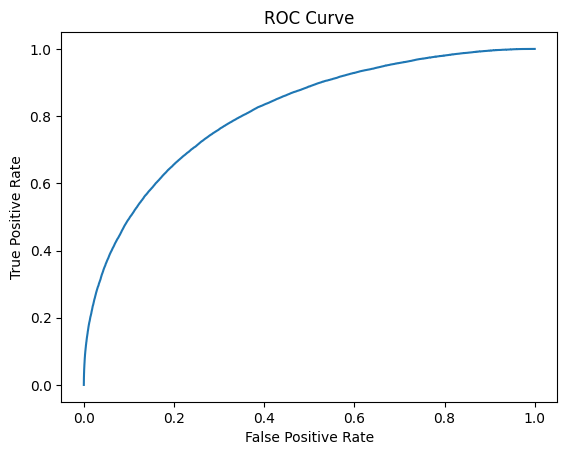

In [200]:
#Постройте график AUC-ROC:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()